In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.special

from estimator_model.causal_tree import CausalTree

In [2]:
np.random.seed(123)
n_samples = 2000
n_features = 10
n_treatments = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + np.random.normal(0, .5, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [3]:
adjustment = []
outcome = 'outcome'
treatment = 'treatment'
data_dict = {
    'treatment': T.reshape(-1,),
    'outcome': y.reshape(-1, ),
}
test_data_dict = {}
for i in range(X.shape[1]):
    data_dict[f'w_{i}'] = X[:, i].reshape(-1, )
    test_data_dict[f'w_{i}'] = X_test[:, i].reshape(-1, )
    adjustment.append(f'w_{i}')
data = pd.DataFrame(data_dict)
test_data = pd.DataFrame(test_data_dict)
data.head()

,treatment,outcome,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9
0,0.0,0.313885,-1.085631,0.997345,0.282978,-1.506295,-0.578600,1.651437,-2.426679,-0.428913,1.265936,-0.866740
1,0.0,-0.306026,-0.678886,-0.094709,1.491390,-0.638902,-0.443982,-0.434351,2.205930,2.186786,1.004054,0.386186
2,1.0,0.909253,0.737369,1.490732,-0.935834,1.175829,-1.253881,-0.637752,0.907105,-1.428681,-0.140069,-0.861755
3,0.0,-0.271350,-0.255619,-2.798589,-1.771533,-0.699877,0.927462,-0.173636,0.002846,0.688223,-0.879536,0.283627
4,0.0,0.000403,-0.805367,-1.727669,-0.390900,0.573806,0.338589,-0.011830,2.392365,0.412912,0.978736,2.238143


In [4]:
data[treatment].value_counts()

0.0    1020
1.0     980
Name: treatment, dtype: int64

In [5]:
ct = CausalTree()
ct.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment
)
ct_pred = ct.estimate(data=test_data)

In [6]:
ct.tree.predict(ct._wv.astype(np.float32))

array([[ 0.31388521],
       [-0.30602605],
       [ 0.9092534 ],
       ...,
       [-0.28274488],
       [ 1.14424285],
       [ 0.92325254]])

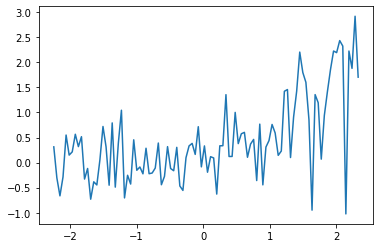

In [7]:
for t in range(n_treatments):
    plt.plot(X_test[:, 0], ct_pred[:, t])
plt.show()